#Implementation 2 - ARIMA Model

For the NVDA stock price prediction, I opted for the ARIMA(0,1,0) model after careful analysis and model comparison. The choice of (0,1,0) indicates that I am relying on a simple differencing of the series and with the use of the auto_arima function. The decision for a differencing order of 1 (d=1) was made to achieve stationarity, as stock prices often exhibit a trend, and differencing can help stabilize the mean of the series. Meanwhile, the decision for p=0 and q=0 suggests that the data did not exhibit significant autoregressive or moving average behaviors that warranted inclusion in the model, or that other models with these components did not significantly improve the forecast accuracy. In essence, the ARIMA(0,1,0) model was chosen for its simplicity and effectiveness in capturing the essential patterns in the NVDA stock price without overcomplicating the model.



##Importing Python Libraries

In [1]:
!pip install pmdarima
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.0 MB/s eta 0:00:00


##Read in the NVDA Dataset

In [2]:
df = pd.read_csv('ARIMA_NVDA.csv')

##Exploratory Data Analysis on NVDA Dataset

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,131.042496,136.524994,129.625000,131.134995,130.851624,56064000
1,2021-01-05,130.997498,134.434998,130.869995,134.047501,133.757828,32276000
2,2021-01-06,132.225006,132.449997,125.860001,126.144997,125.872383,58042400
3,2021-01-07,129.675003,133.777496,128.865005,133.440002,133.151642,46148000
4,2021-01-08,133.625000,134.210007,130.419998,132.767502,132.480606,29252800


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706 entries, 0 to 705
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       706 non-null    object 
 1   Open       706 non-null    float64
 2   High       706 non-null    float64
 3   Low        706 non-null    float64
 4   Close      706 non-null    float64
 5   Adj Close  706 non-null    float64
 6   Volume     706 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 38.7+ KB


In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,706.000000,706.000000,706.000000,706.000000,706.000000,7.060000e+02
mean,233.752110,238.357071,229.094823,233.921887,233.734157,4.618909e+07
std,99.444833,100.900238,97.627618,99.200945,99.242848,1.770778e+07
min,109.709999,117.349998,108.129997,112.269997,112.201363,1.462760e+07
25%,157.189995,160.302498,154.487499,157.529999,157.421997,3.430865e+07
50%,204.431252,206.839996,201.284996,204.689995,204.382981,4.529630e+07
75%,274.754997,280.224991,271.042488,275.977509,275.725083,5.641910e+07
max,502.160004,502.660004,489.579987,493.549988,493.509338,1.543911e+08


In [6]:
#Convert the Date column to a datetime object
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

##Visualising the Close Prices of NVDA

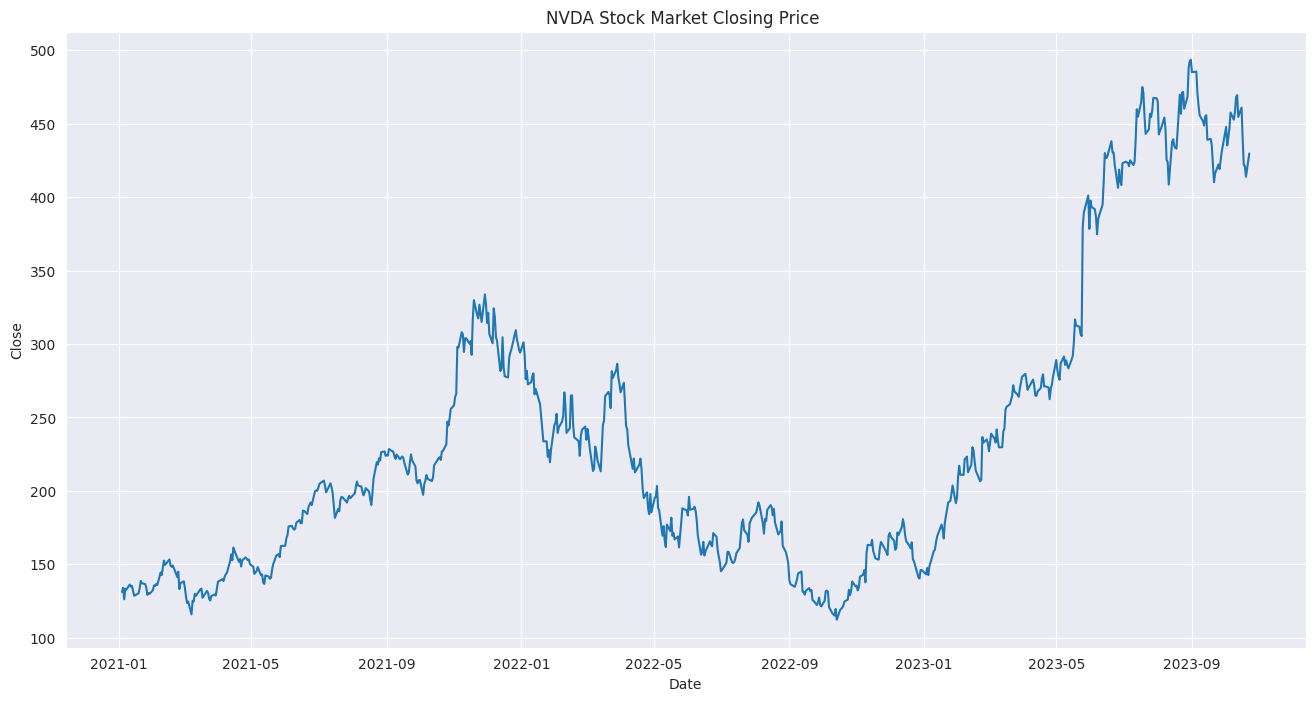

In [7]:
plt.figure(figsize=(16,8))
sns.set_style('darkgrid')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('NVDA Stock Market Closing Price ')
plt.plot(df['Close'])

##Testing if our data is already stationary

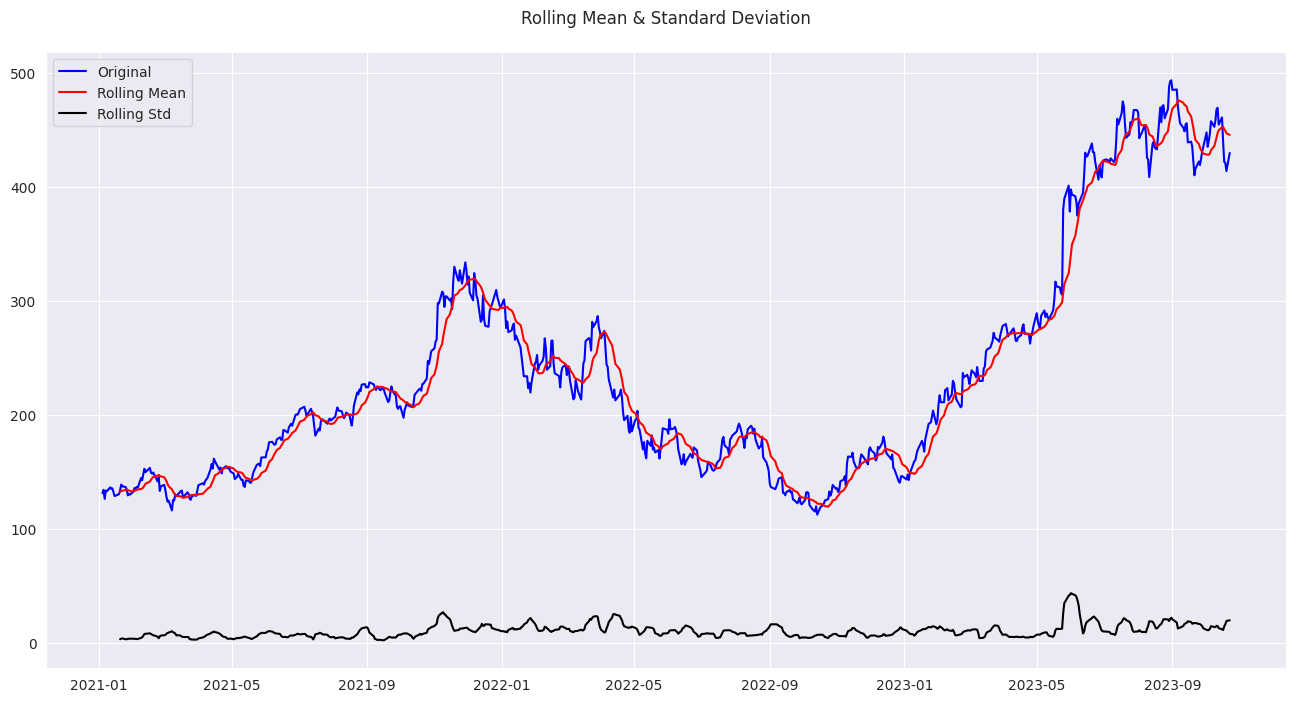

Results of Dickey Fuller Test:

Test Statistic                  -0.443629
p-value                          0.902556
No. of Lags used                 0.000000
Number of observations used    705.000000
Critical Value (1%)             -3.439660
Critical Value (5%)             -2.865648
Critical Value (10%)            -2.568958
dtype: float64


In [8]:
def test_stationary(timeseries):
  # Rolling statistics
  movingAverage = timeseries.rolling(window=12).mean()
  movingSTD = timeseries.rolling(window=12).std()

  # Plot rolling statistics
  plt.figure(figsize=(16,8))
  plt.plot(timeseries, color='blue', label='Original')
  plt.plot(movingAverage, color='red', label='Rolling Mean')
  plt.plot(movingSTD, color='black', label='Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation\n')
  plt.show(block=False)

  # Dickey Fuller test
  print('Results of Dickey Fuller Test:\n')
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'No. of Lags used', 'Number of observations used'])
  for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)' %key] = value
  print(dfoutput)

test_stationary(df['Close'])

p-value is much greater than 0.05, hence we cannot reject the null hypothesis that the time series is non-stationary.

##Separate Trend and Seasonality from the time series

<Figure size 1000x600 with 0 Axes>

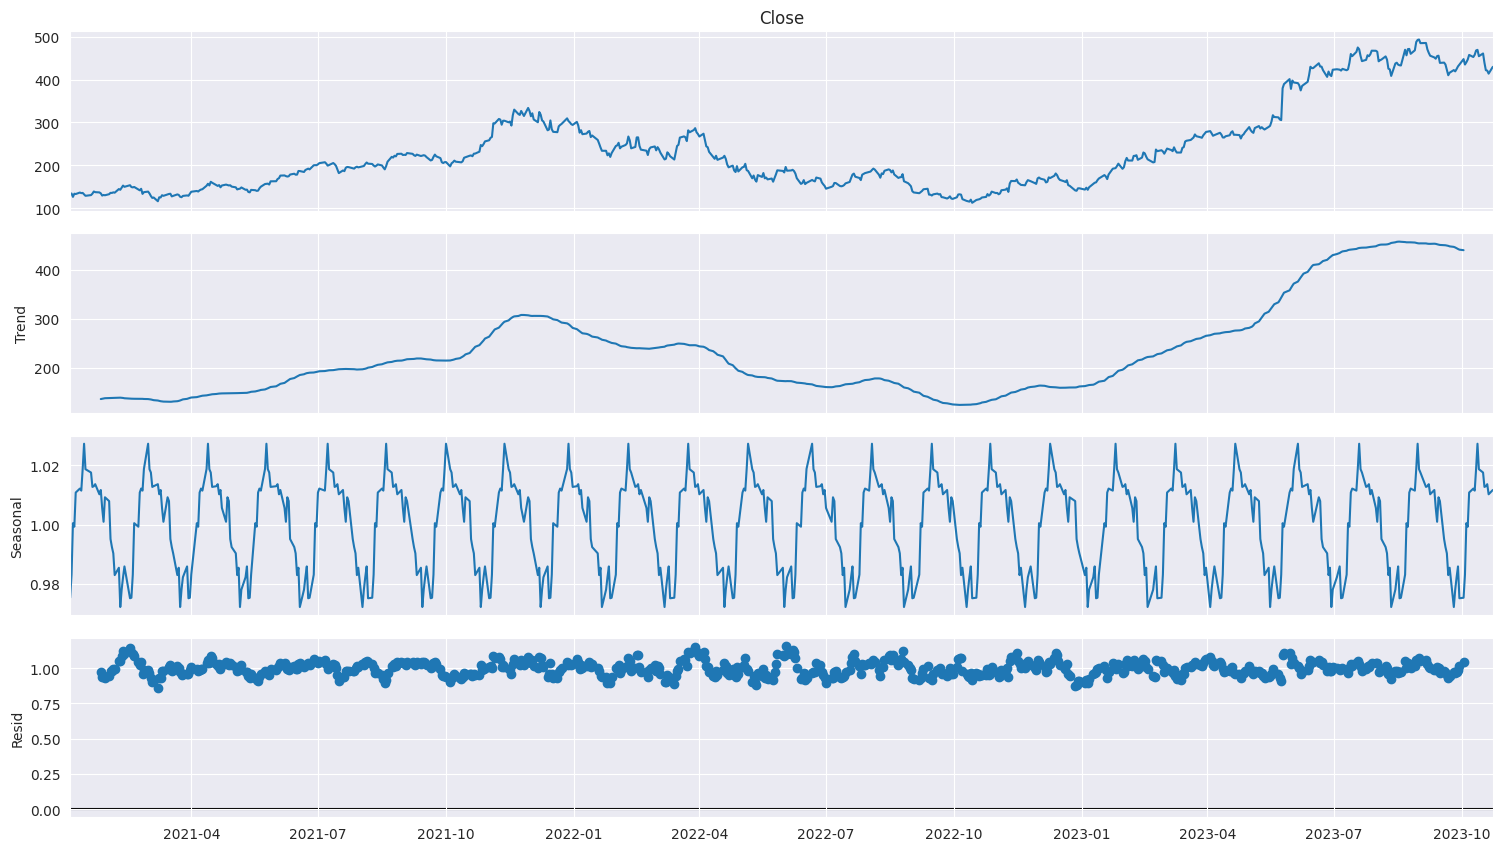

In [9]:
result = seasonal_decompose(df['Close'], model='multiplicative', period=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16,9)

We start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

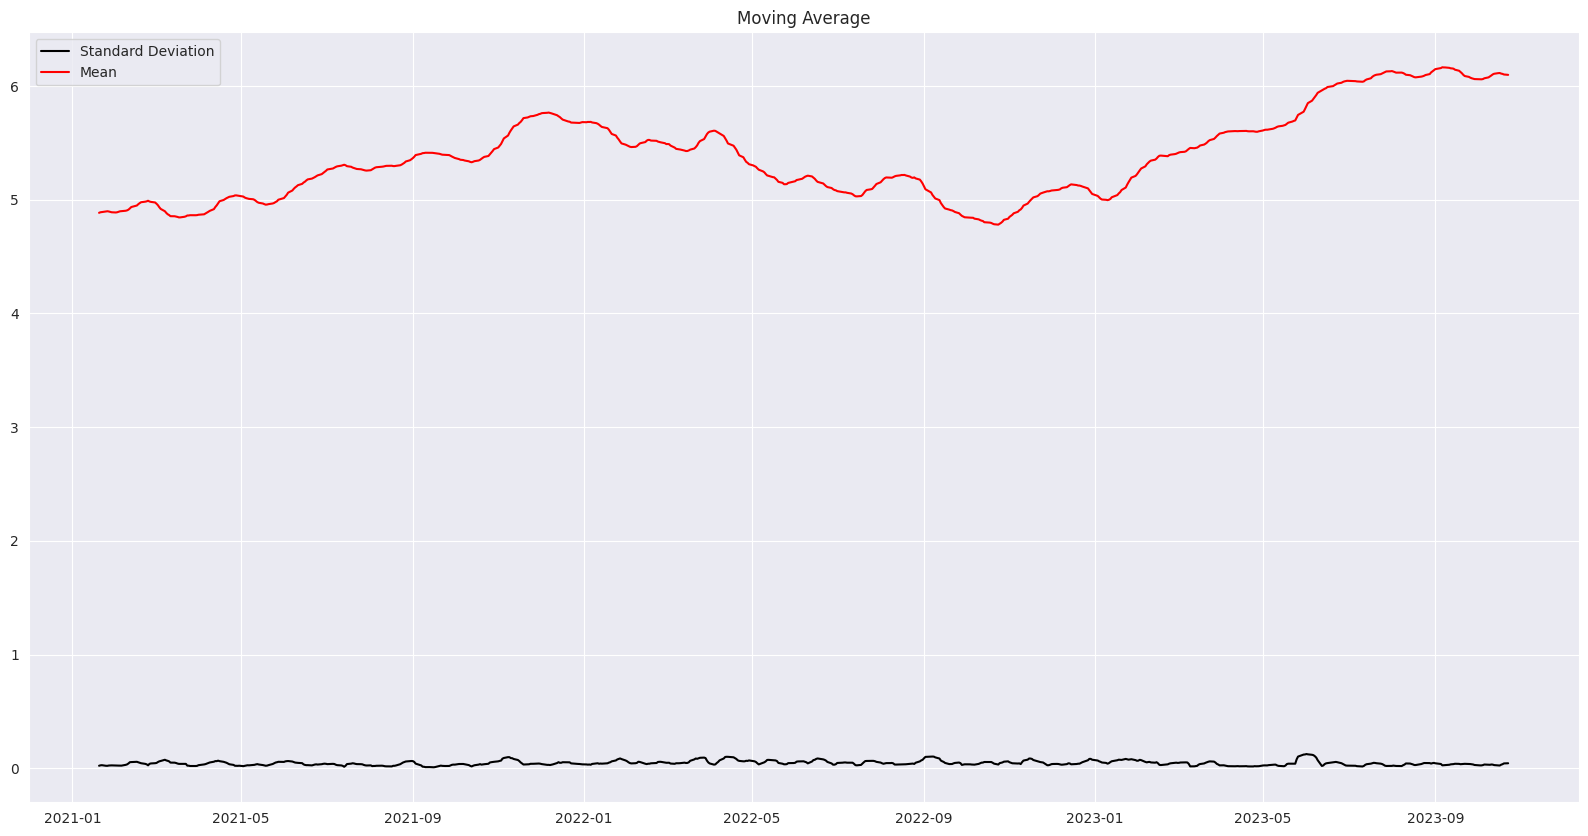

In [10]:
rcParams['figure.figsize'] = 20,10
df_close_log = np.log(df['Close'])
moving_average = df_close_log.rolling(12).mean()
std_dev = df_close_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color='black', label = 'Standard Deviation')
plt.plot(moving_average, color='red', label='Mean')
plt.legend()
plt.show()

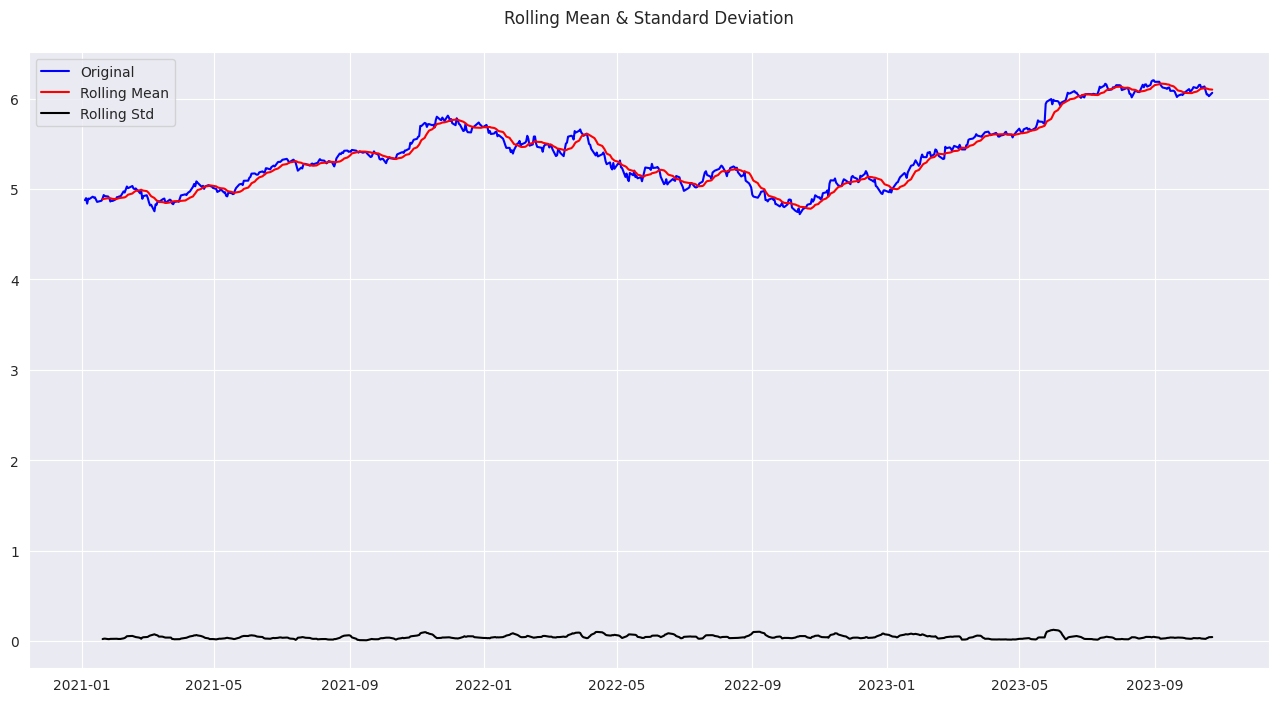

Results of Dickey Fuller Test:

Test Statistic                  -0.836162
p-value                          0.808268
No. of Lags used                 0.000000
Number of observations used    705.000000
Critical Value (1%)             -3.439660
Critical Value (5%)             -2.865648
Critical Value (10%)            -2.568958
dtype: float64


In [11]:
test_stationary(df_close_log)

Results of Dickey Fuller Test:

Test Statistic                 -26.864148
p-value                          0.000000
No. of Lags used                 0.000000
Number of observations used    704.000000
Critical Value (1%)             -3.439673
Critical Value (5%)             -2.865654
Critical Value (10%)            -2.568961
dtype: float64


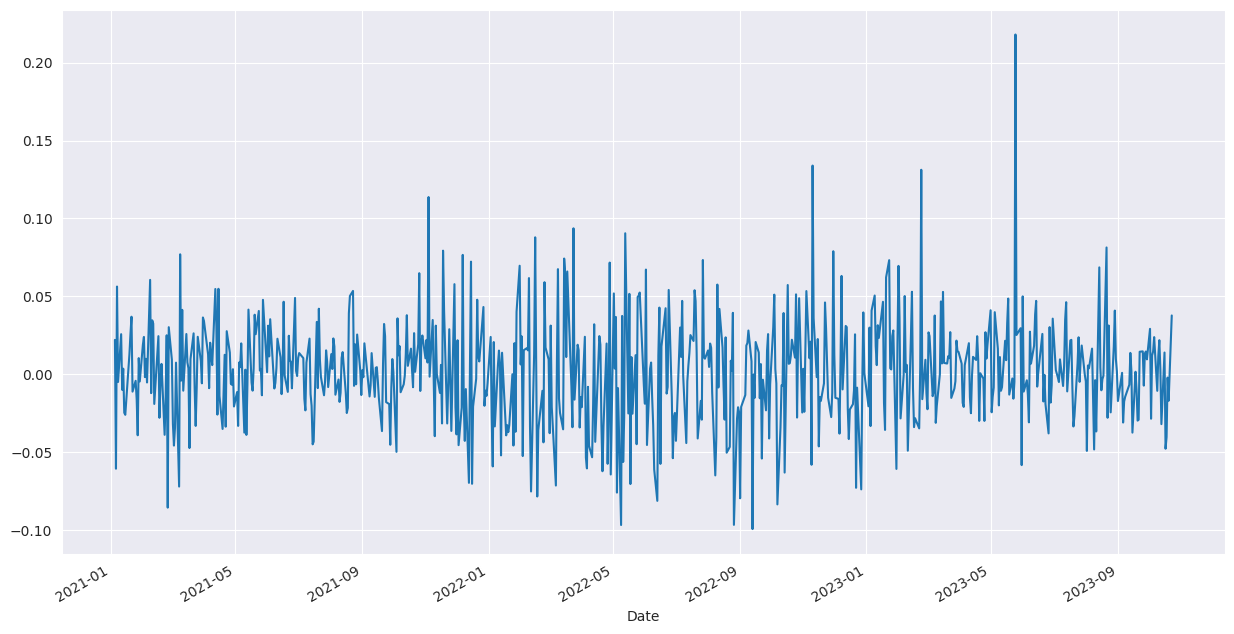

In [12]:
diff_1_logclose = df_close_log.diff().dropna()
diff_1_logclose.plot(figsize=(15,8))


def adf_test(timeseries):
  print('Results of Dickey Fuller Test:\n')
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'No. of Lags used', 'Number of observations used'])
  for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)' %key] = value
  print(dfoutput)


adf_test(diff_1_logclose)

##Visualising the PACF and ACF grphs of the data

In [13]:
def pacf(col):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
    ax1.plot(col)
    ax1.set_title('The Column Diff')
    plot_pacf(col, method='ywm', ax=ax2);


def acf(col):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
    ax1.plot(col)
    ax1.set_title('The Column Diff')
    plot_acf(col, ax=ax2);

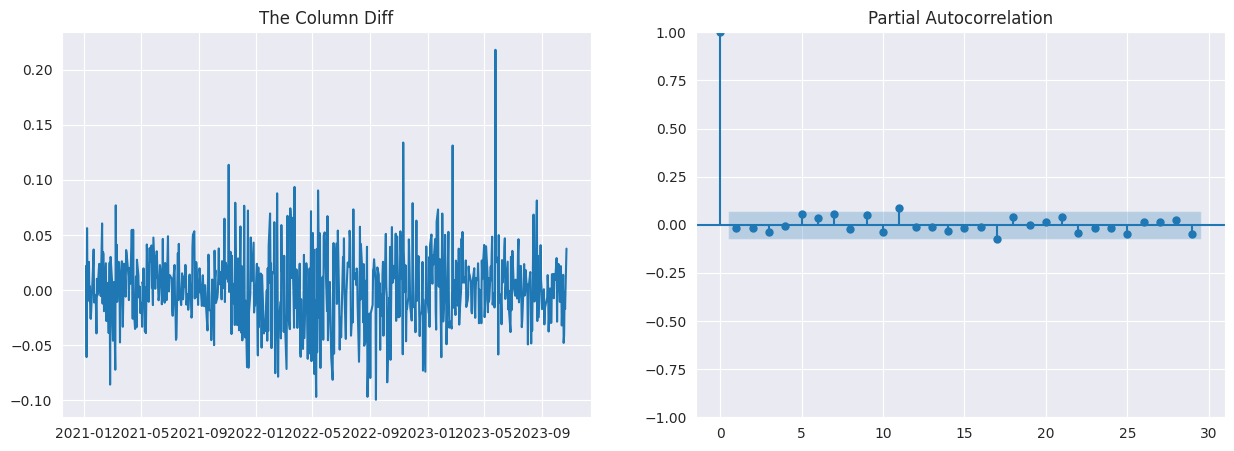

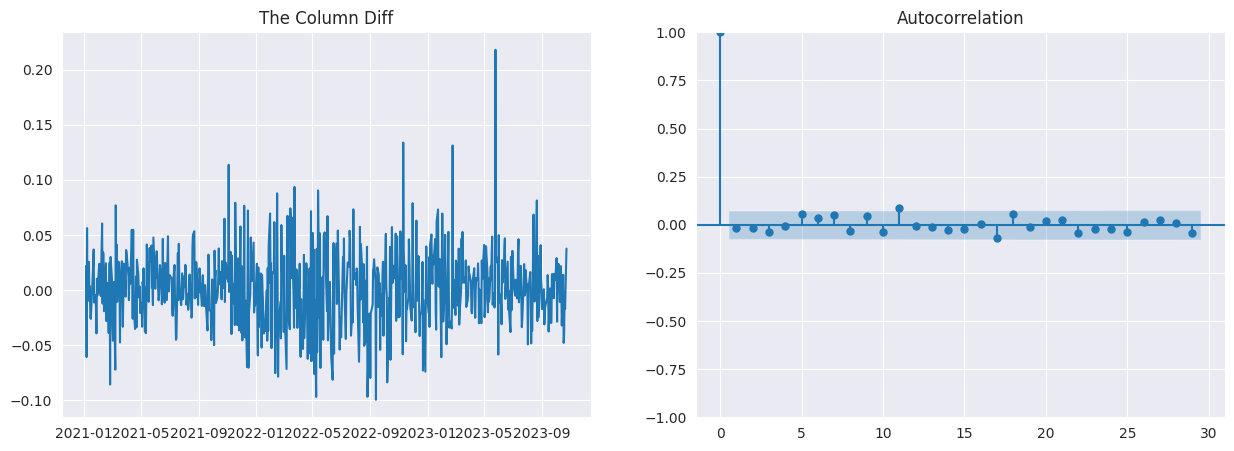

In [14]:
pacf(diff_1_logclose)
acf(diff_1_logclose)

##Splitting Data into training and test set

In [15]:
train_data, test_data = df_close_log[3:int(len(df_close_log)*0.9)], df_close_log[int(len(df_close_log)*0.9):]


##Visualising the training and test sets

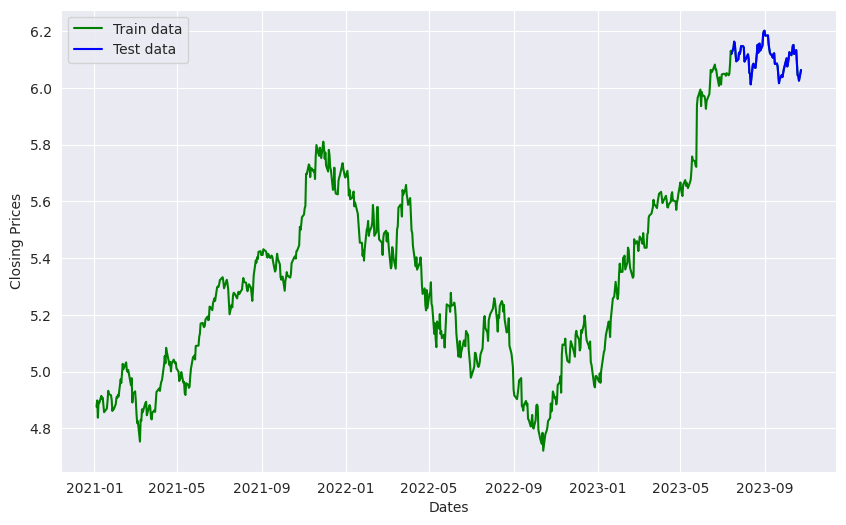

In [16]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_close_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

##Using Auto ARIMA function to find our optimal p and q values

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[30] intercept   : AIC=-2452.729, Time=3.31 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=-2454.728, Time=0.24 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=-2450.755, Time=1.84 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=-2450.763, Time=8.92 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=-2454.692, Time=0.32 sec
 ARIMA(0,1,0)(1,0,0)[30] intercept   : AIC=-2452.724, Time=2.34 sec
 ARIMA(0,1,0)(1,0,1)[30] intercept   : AIC=-2450.733, Time=7.63 sec
 ARIMA(1,1,0)(0,0,0)[30] intercept   : AIC=-2452.760, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=-2452.762, Time=0.99 sec
 ARIMA(1,1,1)(0,0,0)[30] intercept   : AIC=-2450.761, Time=2.69 sec

Best model:  ARIMA(0,1,0)(0,0,0)[30] intercept
Total fit time: 28.650 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  632
Model:               SARIMAX(0, 1, 0)   

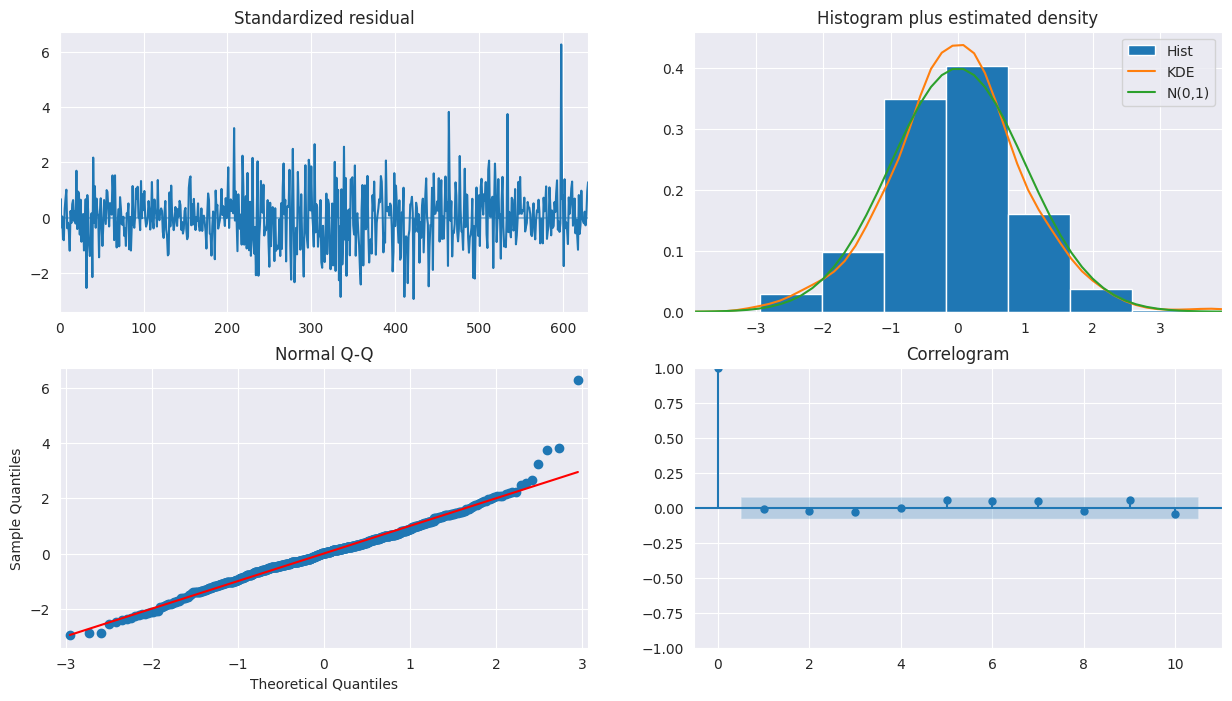

In [17]:
#Auto ARIMA function
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',
                      max_p=7,
                      max_q=7,
                      m=30,
                      d=None,
                      seasonal=True,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [18]:
params = model_autoARIMA.get_params()

##Fitting the ARIMA model with optimal parameters

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

model = sm.tsa.SARIMAX(train_data,
                       order=params['order'],
                       seasonal_order=params['seasonal_order'],
                       trend=params['trend'],
                       enforce_stationarity=False,
                       enforce_invertibility=False)
fitted_model = model.fit(maxiter=params['maxiter'],
                         method=params['method'],
                         start_params=params['start_params'])
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  632
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1225.910
Date:                Tue, 24 Oct 2023   AIC                          -2449.821
Time:                        14:40:16   BIC                          -2445.375
Sample:                             0   HQIC                         -2448.094
                                - 632                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0012   4.32e-05     27.664      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               223.57
Prob(Q):                              0.86   Pr

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


##Forecasting the stock prices on the test dataset, keeping the 95% confidence level

In [20]:
forecast_obj = fitted_model.get_forecast(steps=len(test_data))
forecast_values = forecast_obj.predicted_mean

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [21]:
fc_series = pd.Series(forecast_values.values, index=test_data.index)

In [22]:
#convert the predictions and series back to their original values:
fc_series_original = np.exp(fc_series)
train_data = np.exp(train_data)
test_data = np.exp(test_data)

##Visualising our predictions

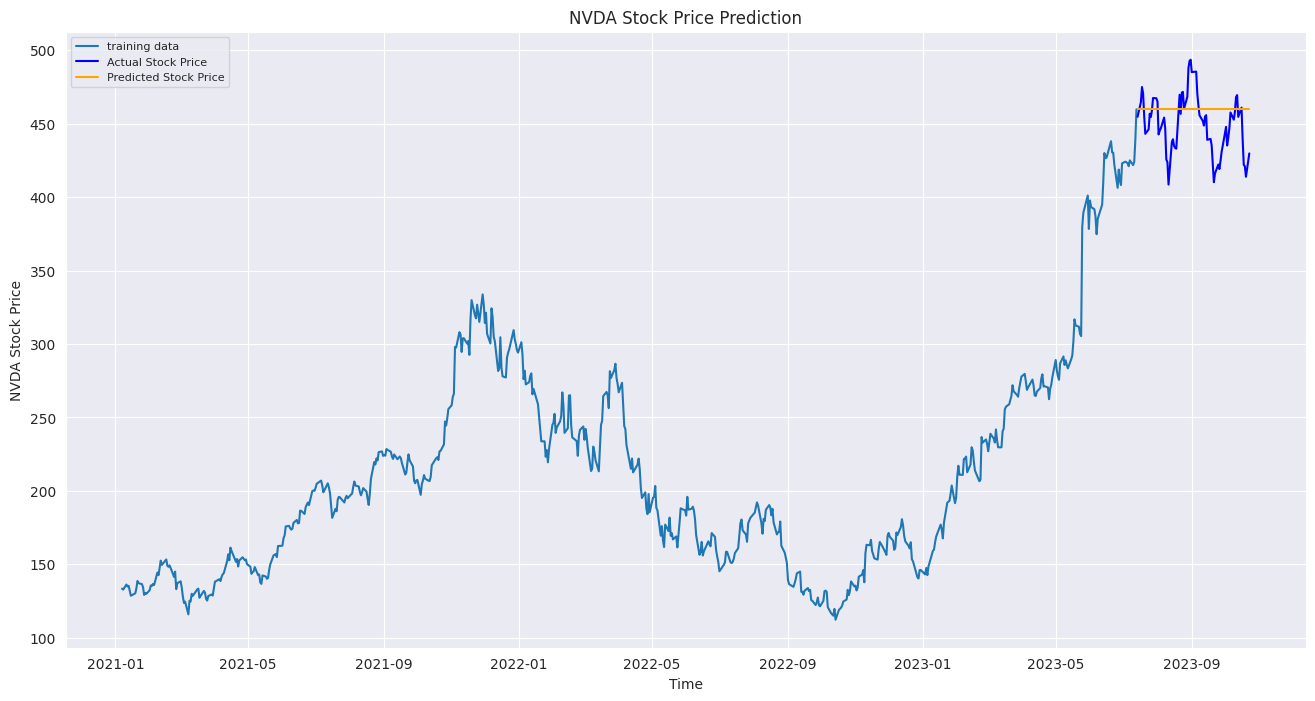

In [23]:
plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series_original, color = 'orange',label='Predicted Stock Price')

plt.title('NVDA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NVDA Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

##Evaluating the ARIMA model

In [24]:
mse = mean_squared_error(test_data, fc_series_original)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc_series_original)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc_series_original))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc_series_original - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 506.16832843263074
MAE: 18.061826042253625
RMSE: 22.498185003075932
MAPE: 0.04112829632129522


Obtaining predictions for the next 10 days

In [28]:
future_forecast = fitted_model.get_forecast(steps=(len(test_data) + 10))

# 2. Extracting the mean forecast
forecast_mean = future_forecast.predicted_mean

# 3. Getting the last 10 forecasts
last_10_forecasts = forecast_mean[-10:]

# If you want these in a DataFrame
last_10_forecasts_df = pd.DataFrame(last_10_forecasts)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


##Exporting the forecasts

In [33]:
last_10_forecasts_df.to_csv("Jerry_Yang_implementation2.csv", header=False, index=False)